In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
from pydataset import data
import warnings
warnings.filterwarnings('ignore')
from matplotlib import style
style.use('ggplot')


Exercises
Do you work for this exercise in either a jupyter notebook named evaluate within your regression-exercises repository. By the end of this exercise you will also create a python script named evaluate, so the overall deliverables for this exercise are the python script and jupyter notebook both with the name evaluate within your regression-exercises repo.



1. Load the tips dataset from either pydataset or seaborn.



In [40]:
tips = data('tips')
tips.head()


,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [41]:
tips.day.value_counts()

Sat     87
Sun     76
Thur    62
Fri     19
Name: day, dtype: int64

In [42]:
#conver gender to is_female with a 1,0 and smoker to 1,0, ,dinner to 1,0 day to number in week
tips = tips.replace(
    ["Female", "Male",'No', 'Yes', 'Dinner','Lunch','Thur','Fri','Sat','Sun'],
    [ 1, 0,0,1,1,0,4,5,6,7]
)
# replace gender with is_female to correlate with above change
tips.rename(columns={"gender": "is_female",'time':'is_dinner'}, inplace=True)
tips.head(3)

,total_bill,tip,sex,smoker,day,is_dinner,size
1,16.99,1.01,1,0,7,1,2
2,10.34,1.66,0,0,7,1,3
3,21.01,3.50,0,0,7,1,3


**Lets check for signifigance and hypothesis testing**

    $H_0$ β= 0 i.e total_bill is not able to explain the variance of the tip.

    $H_1$ β ≠ 0 i.e total_bill is able to explain the variance of the tip.

In [43]:
f_stats, p_values = f_regression(tips, tips.tip, center=True)


In [44]:
features = pd.DataFrame([tips.columns]).T.rename(columns={0:'features'})
features

,features
0,total_bill
1,tip
2,sex
3,smoker
4,day
5,is_dinner
6,size


In [45]:
features['f_stats']=f_stats
features['p_values']=p_values
features

,features,f_stats,p_values
0,total_bill,2.033577e+02,6.692471e-34
1,tip,-1.362339e+17,1.000000e+00
2,sex,1.926155e+00,1.664562e-01
3,smoker,8.506014e-03,9.265932e-01
4,day,4.526200e+00,3.439115e-02
5,is_dinner,3.633815e+00,5.780153e-02
6,size,7.617543e+01,4.300543e-16


In [46]:
#http://www.socr.ucla.edu/Applets.dir/F_Table.html
crit_f_score = 2.802
alpha = 0.5
# drop the y variable
features.drop(index=1, inplace= True)
features['is_significant']= (features.f_stats > crit_f_score) & (features.p_values < alpha)
features

,features,f_stats,p_values,is_significant
0,total_bill,203.357723,6.692471e-34,True
2,sex,1.926155,1.664562e-01,False
3,smoker,0.008506,9.265932e-01,False
4,day,4.526200,3.439115e-02,True
5,is_dinner,3.633815,5.780153e-02,True
6,size,76.175426,4.300543e-16,True


**we can reject the null**

~~$H_0$ β= 0 i.e total_bill is not able to explain the variance of the tip.~~

$H_1$ β ≠ 0 i.e total_bill is able to explain the variance of the tip.

<AxesSubplot:xlabel='total_bill', ylabel='Count'>

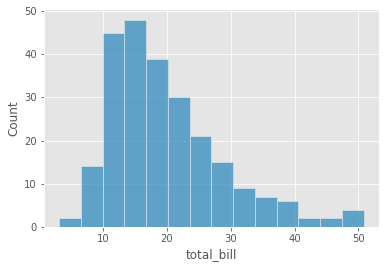

In [47]:
sns.histplot(data = tips, x = 'total_bill')

<AxesSubplot:xlabel='tip', ylabel='Count'>

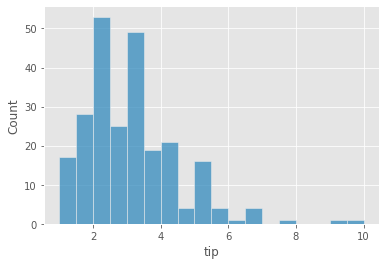

In [48]:
sns.histplot(data = tips, x = 'tip')

2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of tip using total_bill.

        Here is some sample code to get you started:

```python
    from sklearn.linear_model import LinearRegression

    # assuming X and y are already defined
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    Modify and add to the code above as necessary for it to work with the tips dataset.

```

In [49]:
#make the model, normalize, fit, x= total bill, y = tip
model1 = LinearRegression(normalize=True).fit(tips[['total_bill']], tips.tip)
#make yhat column
tips['yhat'] = model1.predict(tips[['total_bill']])
#add in baseline
tips['baseline'] = tips.tip.mean()
tips.head(3)

,total_bill,tip,sex,smoker,day,is_dinner,size,yhat,baseline
1,16.99,1.01,1,0,7,1,2,2.704636,2.998279
2,10.34,1.66,0,0,7,1,3,2.006223,2.998279
3,21.01,3.50,0,0,7,1,3,3.126835,2.998279


3. Plot the residuals for the linear regression model that you made.


In [50]:
# add residuals
# residual = actual - predicted
tips['residual'] = tips.tip - tips.yhat
tips['baseline_residual'] = tips.tip - tips.baseline
tips.head(3)

,total_bill,tip,sex,smoker,day,is_dinner,size,yhat,baseline,residual,baseline_residual
1,16.99,1.01,1,0,7,1,2,2.704636,2.998279,-1.694636,-1.988279
2,10.34,1.66,0,0,7,1,3,2.006223,2.998279,-0.346223,-1.338279
3,21.01,3.50,0,0,7,1,3,3.126835,2.998279,0.373165,0.501721


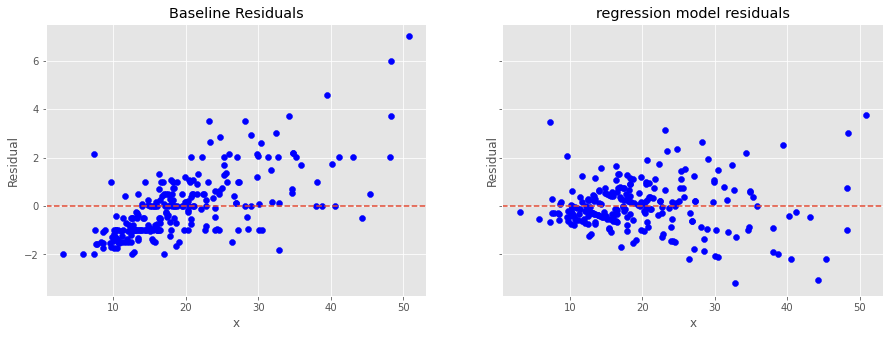

In [51]:
# residual plots (x vs residual)

#plt.figure(figsize = (11,5), sharey=True)

# rows, cols, placement
# one row, two columns, first plot
fig, ax = plt.subplots(1,2,sharey=True, figsize = (15,5))
plt.subplot(121)
plt.scatter(tips.total_bill, tips.baseline_residual, color = 'blue')
plt.axhline(y = 0, ls = '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(tips.total_bill, tips.residual, color = 'blue')
plt.axhline(y = 0, ls = '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.title('regression model residuals');


4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.


In [52]:
# lets make a new df to hold relevant info
df = tips[['total_bill', 'tip', 'yhat', 'baseline', 'residual', 'baseline_residual']]
# add in residuals^2
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2
df.head(3)

,total_bill,tip,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
1,16.99,1.01,2.704636,2.998279,-1.694636,-1.988279,2.871792,3.953252
2,10.34,1.66,2.006223,2.998279,-0.346223,-1.338279,0.119870,1.790990
3,21.01,3.50,3.126835,2.998279,0.373165,0.501721,0.139252,0.251724


In [53]:
# calculate metrics

# mean squared error (MSE)
MSE = mean_squared_error(df.tip, df.yhat)
MSE_baseline = mean_squared_error(df.tip, df.baseline)
# sum of squared errors (SSE)
SSE = MSE * len(df)
SSE_baseline = MSE_baseline * len(df)
# root mean squared error (RMSE)
RMSE = mean_squared_error(df.tip, df.yhat, squared = False)
RMSE_baseline = mean_squared_error(df.tip, df.baseline, squared=False)
# total sum of squares (TSS)
TSS = SSE_baseline
# explained sum of squares (ESS)
ESS = TSS-SSE
# r^2
R2 = ESS/TSS
model_metrics = pd.DataFrame(np.array(['SSE', 'MSE','RMSE','TSS','ESS','R2']), columns=['metric'])
model_metrics['model_error'] = np.array([SSE,  MSE, RMSE, TSS, ESS, R2 ])
model_metrics



,metric,model_error
0,SSE,252.788744
1,MSE,1.036019
2,RMSE,1.017850
3,TSS,465.212477
4,ESS,212.423733
5,R2,0.456617



5. Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average tip amount).


In [54]:
baseline_metrics = pd.DataFrame(np.array(['SSE', 'MSE','RMSE']), columns=['metric'])
baseline_metrics['baseline_error'] = np.array([SSE_baseline,  MSE_baseline, RMSE_baseline])
baseline_metrics

,metric,baseline_error
0,SSE,465.212477
1,MSE,1.906609
2,RMSE,1.380800



6. Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.


In [55]:
#join the model metrics and baseline metrics
metrics = pd.merge(model_metrics,baseline_metrics)
# add boolean column to compare errors
metrics['model_better'] = metrics['model_error'] < metrics['baseline_error']
metrics

,metric,model_error,baseline_error,model_better
0,SSE,252.788744,465.212477,True
1,MSE,1.036019,1.906609,True
2,RMSE,1.017850,1.380800,True



7. What is the amount of variance explained in your model?


In [56]:
#from previous calc
model_metrics[model_metrics['metric']=='R2']


,metric,model_error
5,R2,0.456617


In [57]:
#calc using sklearn built-in
r2_score(df.tip, df.yhat)

0.45661658635167657


8.  Is your model better than the baseline model?



In [58]:
#its better on all three metrics
metrics

,metric,model_error,baseline_error,model_better
0,SSE,252.788744,465.212477,True
1,MSE,1.036019,1.906609,True
2,RMSE,1.017850,1.380800,True


In [59]:
#assume alpha of 0.5
slope, intercept, r, p, se = stats.linregress(tips.total_bill, tips.tip)
slope, intercept, r, p, se, r**2
#slope is not zero, p < alpha

(0.1050245173843534,
 0.9202696135546726,
 0.6757341092113641,
 6.692470646864404e-34,
 0.007364789848762602,
 0.4566165863516758)

9. Create a file named evaluate.py that contains the following functions.

        plot_residuals(y, yhat): creates a residual plot

        regression_errors(y, yhat): returns the following values:

                sum of squared errors (SSE)

                explained sum of squares (ESS)

                total sum of squares (TSS)

                mean squared error (MSE)

                root mean squared error (RMSE)

        baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model
        
        better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false


In [100]:
#write the functions to be stored in evaluate.py

def plot_residuals(y, yhat):
    '''plot residuals given y and yhat'''
    residuals = y - yhat
    plt.hlines(0, y.min(), y.max(), ls='--')
    plt.scatter(y, residuals, color='blue')
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('y value ($y$)')
    plt.title('Actual vs Residual')
    plt.show()

def regression_errors(y, yhat):
    '''return metrics'''
    residuals = y - yhat
    return pd.Series({
        'SSE': (residuals**2).sum(),
        'ESS': ((yhat-y.mean())**2).sum(),
        'TSS': ((y-yhat.mean())**2).sum(),
        'MSE': mean_squared_error(y, yhat),
        'RMSE': mean_squared_error(y, yhat)**0.5,
    })

def baseline_mean_errors(y):
    '''return baseline metrics'''
    # make a series of the baseline value
    mean=pd.Series([y.mean()])
    # repeat the value to make a correctly sized series to match y
    mean = mean.repeat(len(y))
    residuals = y - mean
    return pd.Series({
        'SSE': (residuals**2).sum(),
        'MSE': mean_squared_error(y, mean),
        'RMSE': mean_squared_error(y, mean)**0.5,
    })

def better_than_baseline(y, yhat):
    '''compare model results to baseline based on mean'''
    # make a series of the baseline value
    mean=pd.Series([y.mean()])
    # repeat the value to make a correctly sized series to match y
    mean = mean.repeat(len(y))
    rmse_baseline = mean_squared_error(y, mean)**0.5,
    rmse_model = mean_squared_error(y, yhat)**0.5,
    is_better = rmse_model < rmse_baseline
    # print result
    print (f'based on RMSE, is the model better: {is_better}')
    # return a boolean to be used in a df
    return is_better

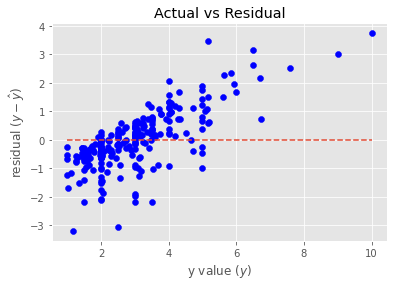

In [90]:
plot_residuals(tips.tip,tips.yhat)


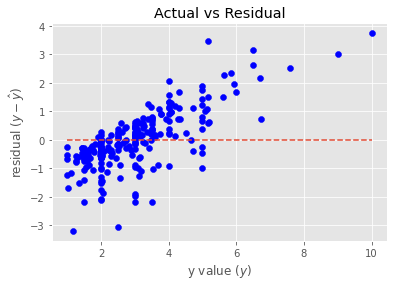

In [99]:
evaluate.plot_residuals(tips.tip,tips.yhat)

In [91]:
regression_errors(tips.tip,tips.yhat)

SSE     252.788744
ESS     212.423733
TSS     465.212477
MSE       1.036019
RMSE      1.017850
dtype: float64

In [101]:
evaluate.regression_errors(tips.tip,tips.yhat)

SSE     252.788744
ESS     212.423733
TSS     465.212477
MSE       1.036019
RMSE      1.017850
dtype: float64

In [92]:
baseline_mean_errors(tips.tip)

SSE     0.000000
MSE     1.906609
RMSE    1.380800
dtype: float64

In [102]:
evaluate.baseline_mean_errors(tips.tip)

SSE     0.000000
MSE     1.906609
RMSE    1.380800
dtype: float64

In [95]:
better_than_baseline(tips.tip,tips.yhat)

based on RMSE, is the model better: True


True

In [103]:
evaluate.better_than_baseline(tips.tip,tips.yhat)

based on RMSE, is the model better: True


True

10. Load the mpg dataset and fit a model that predicts highway mileage based on engine displacement. Take a look at all the regression evaluation metrics, and determine whether this model is better than the baseline model. Use the functions from your evaluate.py to help accomplish this.

In [104]:
mpg = data('mpg')
mpg.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


In [105]:
#make the model, normalize, fit, x= displ, y = hwy
model2 = LinearRegression(normalize=True).fit(mpg[['displ']], mpg.hwy)
#make yhat column
mpg['yhat'] = model2.predict(mpg[['displ']])
#add in baseline
mpg['baseline'] = mpg.hwy.mean()
mpg.head(3)

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class,yhat,baseline
1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact,29.342591,23.440171
2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact,29.342591,23.440171
3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact,28.636473,23.440171


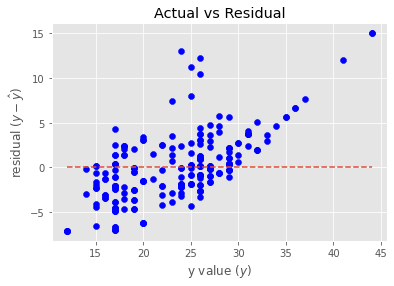

In [107]:
evaluate.plot_residuals(mpg.hwy,mpg.yhat)


In [108]:
evaluate.regression_errors(mpg.hwy,mpg.yhat)


SSE     3413.829009
ESS     4847.833384
TSS     8261.662393
MSE       14.589013
RMSE       3.819557
dtype: float64

In [109]:
evaluate.baseline_mean_errors(mpg.hwy)


SSE      0.000000
MSE     35.306250
RMSE     5.941906
dtype: float64

In [110]:
evaluate.better_than_baseline(mpg.hwy,mpg.yhat)

based on RMSE, is the model better: True


True